# Word clouds for ecommerce labels

In [1]:
import math
from collections import Counter

import numpy as np
import pandas as pd
import nltk

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import tokenization
from wordcloud import WordCloud

# local:
from grid_search import load_ecom_labels, get_sample_output, summarise_by_website

In [2]:
ecom_labels = load_ecom_labels()
sample_output = get_sample_output(ecom_labels)
websites = summarise_by_website(sample_output, ecom_labels)
websites.head()

netloc                                               Text  \
0        41south.nz  To the right is the 3 day NZ MetService foreca...   
1           8.co.nz  Choosing Uncomplicated Secrets Of fdating\n\nG...   
2  a1kitchens.co.nz  DESIGN - MANUFACTURE - INSTALLATION\n\nA1 Kitc...   
3   a1shuttle.co.nz  Ray was born in Blenheim and since 2007 he has...   
4     aboutus.co.nz  New Zealand Sports\n\nSports in New Zealand ar...   

   target                                              words  \
0       0  [to, the, right, is, the, day, nz, metservice,...   
1       0  [choosing, uncomplicated, secrets, of, fdating...   
2       0  [design, manufacture, installation, kitchens, ...   
3       0  [ray, was, born, in, blenheim, and, since, he,...   
4       0  [new, zealand, sports, sports, in, new, zealan...   

                                        tagged_words  
0  ([to, the, right, is, the, day, nz, metservice...  
1  ([choosing, uncomplicated, secrets, of, fdatin...  
2  ([design, manufacture, installation, kitchens,...  
3  ([ray, was, born, in, blenheim, and, since, he...  
4  ([new, zealand, sports, sports, in, new, zeala...

to the right is the day nz metservice forecast for my local area click on warning in the image to see the full detail below is the day forecast generated by aeris weather pwsweather com click here for lightning information in the tasman sea and south pacific areas about this weather station observations are powered by weewx and weatherduino welcome to the about page for this weather station some details about this station observations are powered by weewx and weatherduino observations are powered by weewx and weatherduino observations are powered by weewx and weatherduino observations are powered by weewx and weatherduino observations are powered by weewx and weatherduino observations are powered by weewx and weatherduino observations are powered by weewx and weatherduino observations are powered by weewx and weatherduino observations are powered by weewx and weatherduino observations are powered by weewx and weatherduino observations are powered by weewx and weatherduino observations 

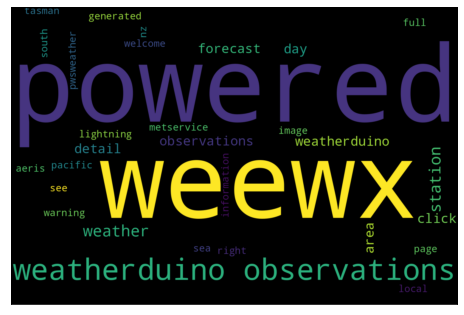

In [3]:
wordcloud_input = ' '.join(websites['words'][0])
wordcloud = WordCloud(width=1500, height=1000).generate(wordcloud_input)
print(wordcloud_input)

fig, ax = plt.subplots(figsize=(8, 12))
ax.imshow(wordcloud, interpolation="bilinear")
ax.set(xticks=[], yticks=[])
plt.show()

## See the difference between ecommerce websites and others

In [4]:
def ecom_vs_not_wclouds(websites_df, collocations=True):
    ecom_true_mask = np.array([True if ecom_labels[netloc] else False 
                               for netloc in websites_df['netloc']])

    ecom_true_words = ' '.join(websites_df[ecom_true_mask]['words'].sum())
    ecom_false_words = ' '. join(websites_df[~ecom_true_mask]['words'].sum())

    ecom_true_wordcloud = WordCloud(width=1800, height=1200, collocations=collocations).generate(ecom_true_words)
    ecom_false_wordcloud = WordCloud(width=1800, height=1200, collocations=collocations).generate(ecom_false_words)

    title_suffixes = []
    if not collocations:
        title_suffixes.append("bigrams=False")
        
    if len(title_suffixes) > 0:
        title_suffix = f" ({', '.join(title_suffixes)})"
    else:
        title_suffix = " (default settings)"
    
    fig, axes = plt.subplots(1, 2, figsize=(24, 8))
    ax = axes.ravel()
    for axi in ax:
        axi.set(xticks=[], yticks=[])

    ax[0].imshow(ecom_true_wordcloud, interpolation="bilinear")
    ax[0].set(title="ecom True" + title_suffix)
    ax[1].imshow(ecom_false_wordcloud, interpolation="bilinear")
    ax[1].set(title="ecom False" + title_suffix)
    plt.show()

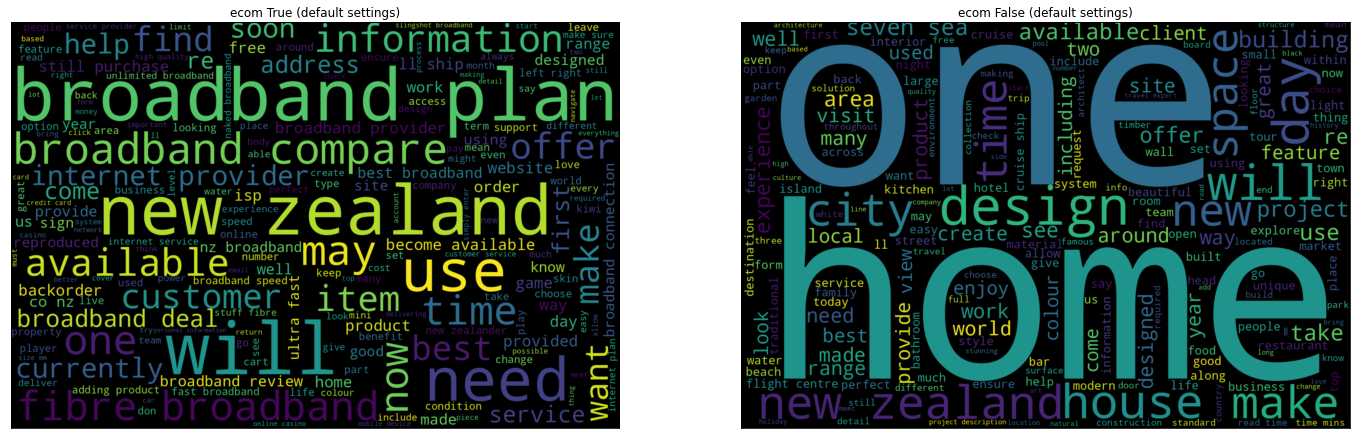

CPU times: user 21.4 s, sys: 385 ms, total: 21.8 s
Wall time: 21.8 s


In [5]:
%%time
ecom_vs_not_wclouds(websites)

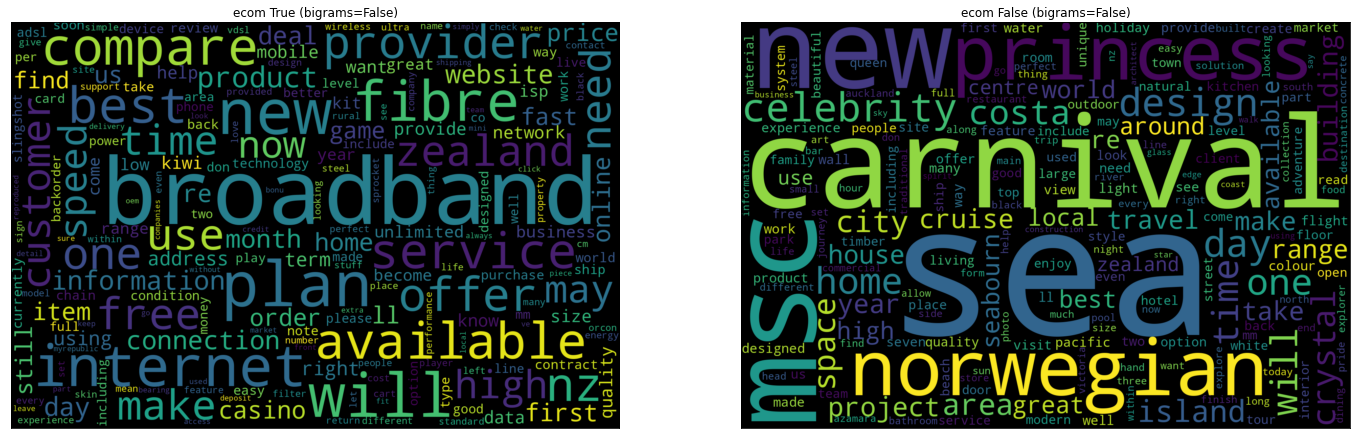

In [6]:
ecom_vs_not_wclouds(websites, collocations=False)

In [7]:
# See which websites have the word 'broadband' in them
broadband_mask = [True if 'broadband' in words else False for words in websites['words']]

for idx in websites[broadband_mask].index:
    print(f"netloc:                {websites.loc[idx, 'netloc']}")
    print(f"total number of words: {len(websites.loc[idx, 'words'])}")
    print(f"number of 'broadband': {Counter(websites.loc[idx, 'words'])['broadband']}")
    print()

netloc:                deciphergroup.co.nz
total number of words: 23919
number of 'broadband': 2

netloc:                old.broadbandcompare.co.nz
total number of words: 63305
number of 'broadband': 1867

netloc:                www.broadbandcompare.co.nz
total number of words: 390164
number of 'broadband': 13118

netloc:                www.cloudink.co.nz
total number of words: 4773
number of 'broadband': 4



In [8]:
# Need a way to reduce the influence of any given website, so that words like
# 'broadband' do not dominate simply because they are extremely frequent on a 
# few websites.

# word freq / num words - per document, then sum??

def get_avg_word_freqs(df):
    unique_words = set(df['words'].sum())
    word_counters = [Counter(words) for words in df['words']]
    len_docs = [len(words) for words in df['words']]
    
    word_freqs = {
        word: [word_counters[i][word] / len_doci for i, len_doci in enumerate(len_docs)]
        for word in unique_words
    }
    avg_word_freqs = {word: np.array(word_freqs[word]).mean() for word in unique_words}
    
    return avg_word_freqs

# Rewrite function to include bigrams (using wordcloud functionality)
def get_avg_word_freqs_bigrams(df):    
    wcloud_obj = WordCloud(collocations=True)
    per_document_word_freqs = [wcloud_obj.process_text(text) for text in df['Text']]
    for i, doc_dict in enumerate(per_document_word_freqs):
        norm_factor = sum(doc_dict.values())
        per_document_word_freqs[i] = {'_'.join(k.split(' ')): v / norm_factor for k, v in doc_dict.items()}
        # need to normalise to actually get frequencies (or close)
    
    unique_unigrams_and_bigrams = {
        key for list_keys in per_document_word_freqs for key in list_keys.keys()
    }
    avg_word_freqs = {
        word: np.array([doc_dict.get(word, 0) for doc_dict in per_document_word_freqs]).mean()
        for word in unique_unigrams_and_bigrams
    }
    
    # convert list[dict[string -> int]] to dict[string -> list[int]]
#     word_freqs = {word: [doci_word_freqs.get(word, 0) for doci_word_freqs in per_document_word_freqs]
#                   for word in unique_words}
#     avg_word_freqs = {word: np.array(word_freqs[word]).mean() for word in unique_words}
    
    return avg_word_freqs

# NORMALISE NUMBERS?

In [9]:
'_'.join("hello there".split(' '))

'hello_there'

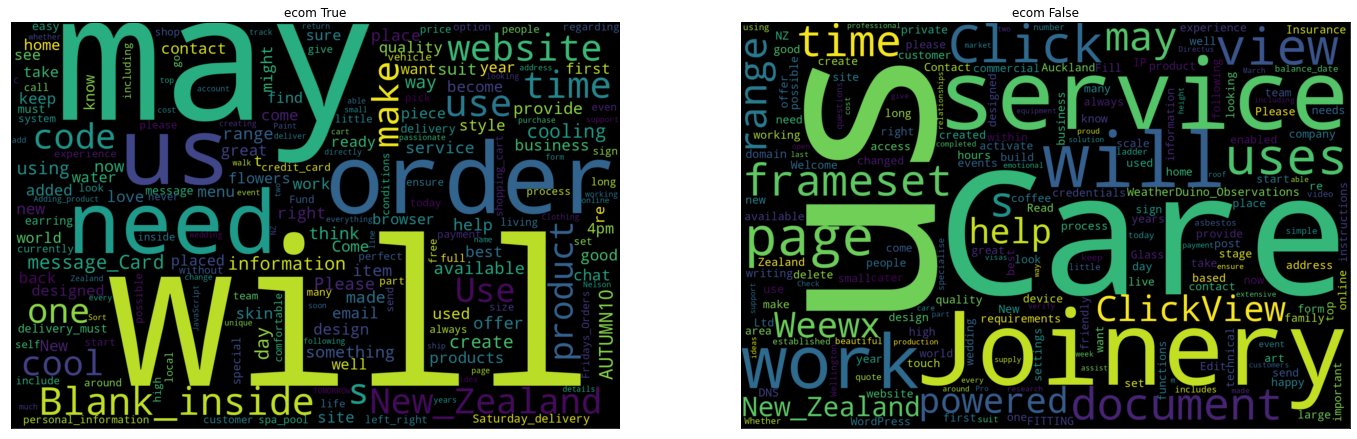

In [10]:
ecom_true_mask = np.array([True if ecom_labels[netloc] else False 
                           for netloc in websites['netloc']])
true_avg_word_freqs = get_avg_word_freqs_bigrams(websites[ecom_true_mask])
false_avg_word_freqs = get_avg_word_freqs_bigrams(websites[~ecom_true_mask])

ecom_true_wordcloud = WordCloud(width=1800, height=1200).generate_from_frequencies(true_avg_word_freqs)
ecom_false_wordcloud = WordCloud(width=1800, height=1200).generate_from_frequencies(false_avg_word_freqs)

fig, axes = plt.subplots(1, 2, figsize=(24, 8))
ax = axes.ravel()
for axi in ax:
    axi.set(xticks=[], yticks=[])

ax[0].imshow(ecom_true_wordcloud, interpolation="bilinear")
ax[0].set(title="ecom True")
ax[1].imshow(ecom_false_wordcloud, interpolation="bilinear")
ax[1].set(title="ecom False")
plt.show()

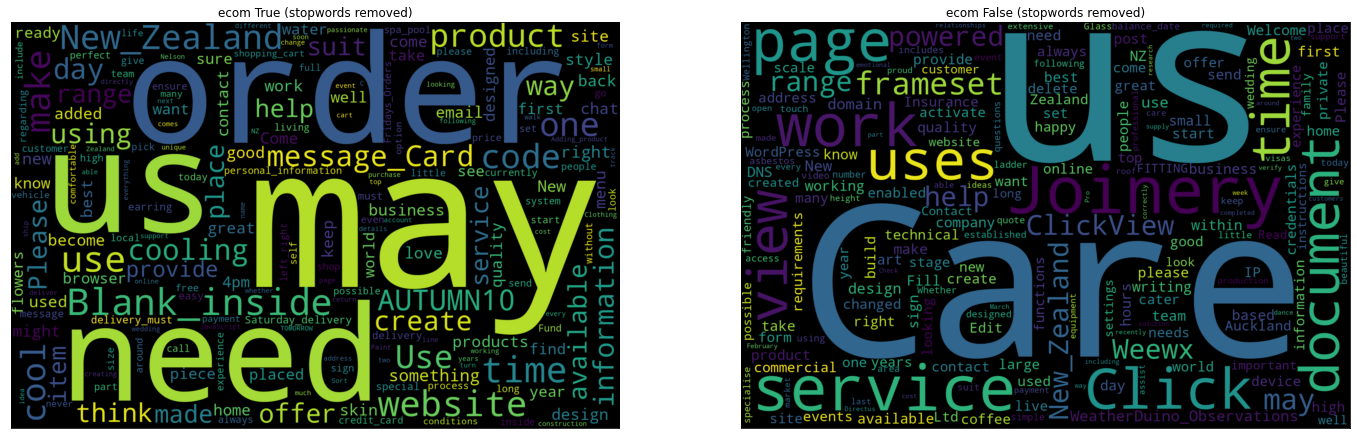

In [11]:
# Now dominated by uninformative words - need to remove 'stopwords'
stops = set(nltk.corpus.stopwords.words('english'))

filtered_true_avg_word_freqs = {k: v for k, v in true_avg_word_freqs.items() if k not in stops}
filtered_false_avg_word_freqs = {k: v for k, v in false_avg_word_freqs.items() if k not in stops}

ecom_true_wordcloud = WordCloud(width=1800, height=1200).generate_from_frequencies(filtered_true_avg_word_freqs)
ecom_false_wordcloud = WordCloud(width=1800, height=1200).generate_from_frequencies(filtered_false_avg_word_freqs)

fig, axes = plt.subplots(1, 2, figsize=(24, 8))
ax = axes.ravel()
for axi in ax:
    axi.set(xticks=[], yticks=[])

ax[0].imshow(ecom_true_wordcloud, interpolation="bilinear")
ax[0].set(title="ecom True (stopwords removed)")
ax[1].imshow(ecom_false_wordcloud, interpolation="bilinear")
ax[1].set(title="ecom False (stopwords removed)")
plt.show()

In [12]:
unique_words = set(websites['words'].sum())

print(f"Number of unique words")
print(f"True             | {len(true_avg_word_freqs.keys())}")
print(f"False            | {len(false_avg_word_freqs.keys())}")
print()
print(f"True, filtered   | {len(filtered_true_avg_word_freqs.keys())}")
print(f"False, filtered  | {len(filtered_false_avg_word_freqs.keys())}")
print()
print(f"Both             | {len(unique_words)}")
print()
print("(NB: there should be overlap between True & False)")

Number of unique words
True             | 40723
False            | 68107

True, filtered   | 40696
False, filtered  | 68080

Both             | 53507

(NB: there should be overlap between True & False)


## Want to do a single wordcloud of the difference between True & False

In [13]:
filt_pos_diff = {word: true_avg_word_freqs.get(word, 0) - false_avg_word_freqs.get(word, 0)
                 for word in unique_words
                 if word not in stops
                }
filt_neg_diff = {word: false_avg_word_freqs.get(word, 0) - true_avg_word_freqs.get(word, 0)
                 for word in unique_words
                 if word not in stops
                }

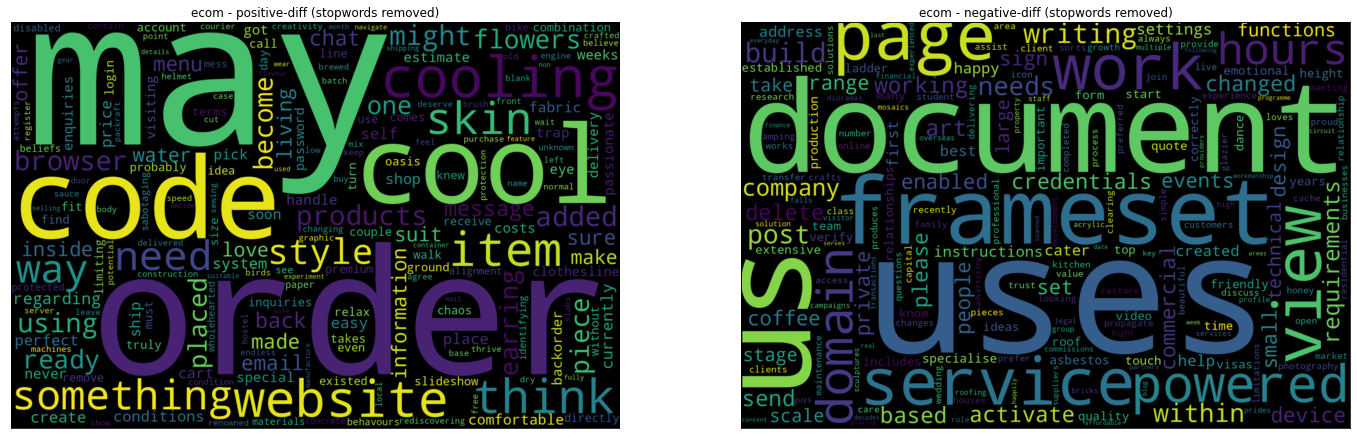

In [14]:
filt_pos_diff_wordcloud = WordCloud(width=1800, height=1200).generate_from_frequencies(filt_pos_diff)
filt_neg_diff_wordcloud = WordCloud(width=1800, height=1200).generate_from_frequencies(filt_neg_diff)

fig, axes = plt.subplots(1, 2, figsize=(24, 8))
ax = axes.ravel()
for axi in ax:
    axi.set(xticks=[], yticks=[])

ax[0].imshow(filt_pos_diff_wordcloud, interpolation="bilinear")
ax[0].set(title="ecom - positive-diff (stopwords removed)")
ax[1].imshow(filt_neg_diff_wordcloud, interpolation="bilinear")
ax[1].set(title="ecom - negative-diff (stopwords removed)")
plt.show()

The left image shows the most frequent words on ecommerce websites, relative to non-ecom websites. The right graph shows the most frequent words on non-ecommerce websites, relative to ecom websites. Essentially, the left and right images show the words that could provide the strongest indication that a website is ecommerce or non-ecommerce, respectively.

## KMeans-clustered ecommerce websites

https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans

In [58]:
ecom_mask = websites['target'] == 1

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(websites[ecom_mask]['Text'])
km = KMeans(n_clusters=5, init='k-means++', random_state=777)
km.fit(X);

In [59]:
for i in range(km.n_clusters): 
    km_mask = km.labels_ == i
    km_websites = websites[ecom_mask][km_mask]
    
    print(f"Cluster {i + 1}:")
    print(', '.join(km_websites['netloc']) + '\n')

Cluster 1:
aimeenicole.co.nz, apostlehotsauce.co.nz, burgerburger.co.nz, cafecoco.co.nz, deepanimation.co.nz, embassy3.co.nz, epicinnovation.co.nz, fujimae.co.nz, www.allurehairstudio.co.nz, www.cargobrewery.co.nz, www.cellarselection.co.nz, www.chillihub.co.nz, www.cliffedge.co.nz

Cluster 2:
autosmart.co.nz, boomboy.co.nz, ecofriend.co.nz, www.conceptskincare.co.nz, www.darkheart.co.nz, www.eclipsepharmacy.co.nz, www.embrayce.co.nz

Cluster 3:
acerental.co.nz, adamas.co.nz, allfence.co.nz, ardo.co.nz, canon.boostwebstore.co.nz, catevolution.co.nz, codingacademy.co.nz, dbrief.co.nz, decal.co.nz, dwights.co.nz, ecospas.co.nz, old.broadbandcompare.co.nz, shop.celebrationsgroup.co.nz, www.amazethecardshop.co.nz, www.atwistedbunch.co.nz, www.bencorp.co.nz, www.broadbandcompare.co.nz, www.casinoblox.co.nz, www.crownbrush.co.nz, www.demeritcheck.co.nz, www.digitalpopup.co.nz, www.donnafarhi.co.nz, www.fairyflowers.co.nz, www.fodda.co.nz, www.freeparking.co.nz, www.fujifilm.co.nz

Cluster 4:

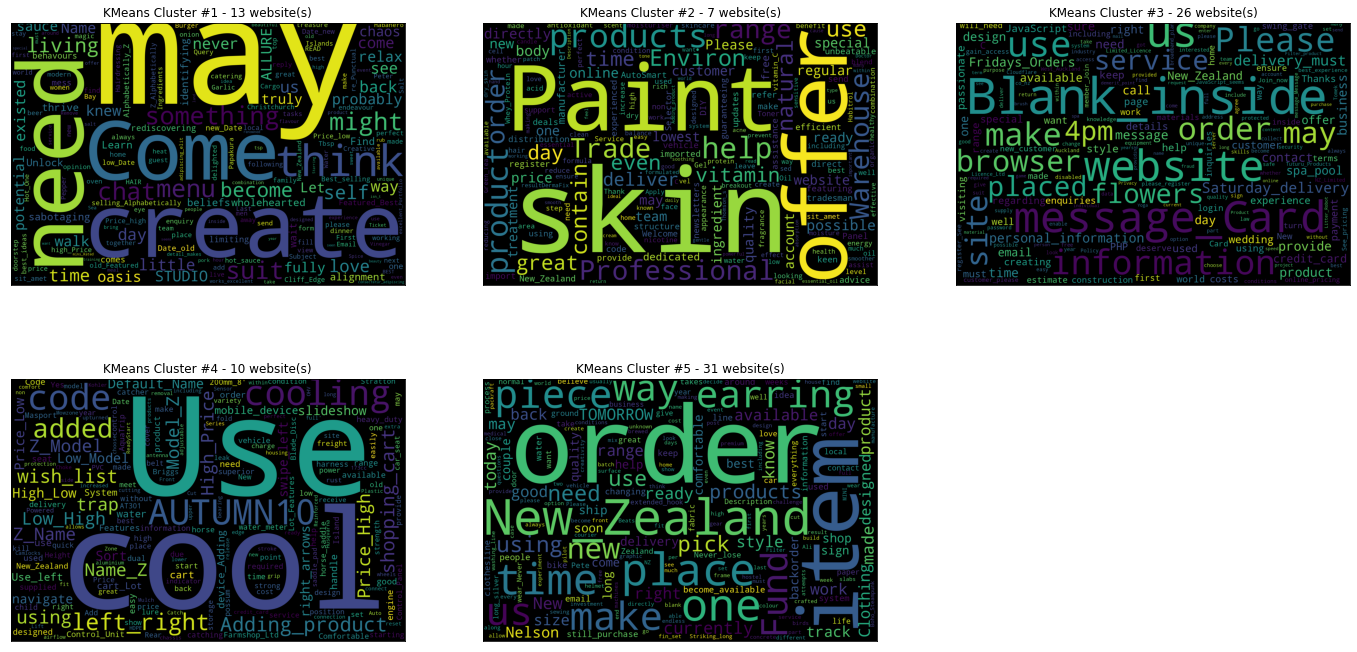

In [60]:
fig, axes = plt.subplots(math.ceil(km.n_clusters / 3), 3,
                         figsize=(24, 6 * math.ceil(km.n_clusters / 3)))
ax = axes.ravel()
for axi in ax:
    axi.set(xticks=[], yticks=[])

for i in range(km.n_clusters): 
    km_mask = km.labels_ == i
    km_websites = websites[ecom_mask][km_mask]
    km_filt_word_freqs = {k: v for k, v in get_avg_word_freqs_bigrams(km_websites).items() 
                          if k not in stops}
    
    km_wcloud = WordCloud(width=1800, height=1200, collocations=False).generate_from_frequencies(km_filt_word_freqs)
    
    ax[i].imshow(km_wcloud)
    ax[i].set(title=f"KMeans Cluster #{i + 1} - {len(km_websites)} website(s)")

# make unused axes invisible
for i in range(km.n_clusters, len(ax)):
    ax[i].set_visible(False)

plt.show()

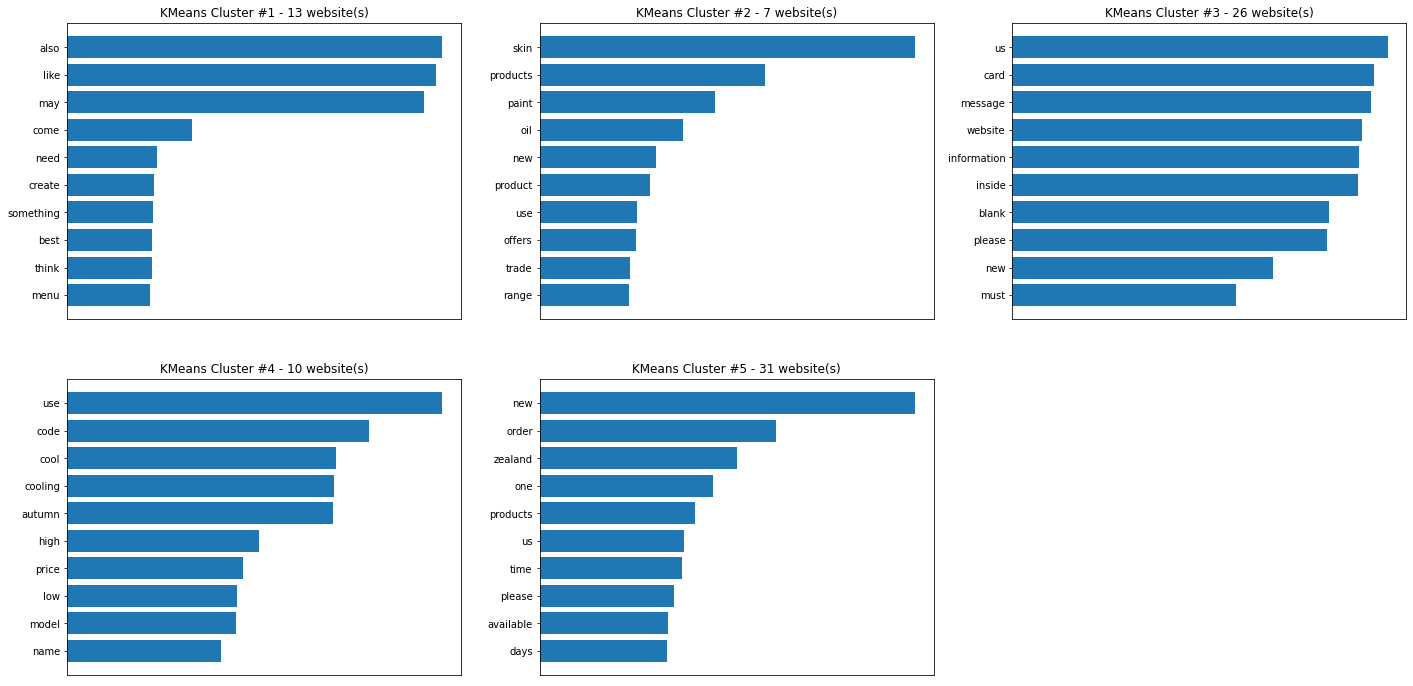

In [61]:
fig, axes = plt.subplots(math.ceil(km.n_clusters / 3), 3,
                         figsize=(24, 6 * math.ceil(km.n_clusters / 3)))
ax = axes.ravel()
for axi in ax:
    axi.set(xticks=[])

for i in range(km.n_clusters): 
    km_mask = km.labels_ == i
    km_websites = websites[ecom_mask][km_mask]
    km_filt_word_freqs = {k: v for k, v in get_avg_word_freqs(km_websites).items() 
                          if k not in stops}
    
    top_word_freqs = Counter(km_filt_word_freqs).most_common(10)[::-1]
    y_pos = range(len(top_word_freqs))
    x_pos = [x for word, x in top_word_freqs]
    y_labels = [word for word, x in top_word_freqs]
    
    ax[i].barh(y_pos, x_pos)
    ax[i].set(title=f"KMeans Cluster #{i + 1} - {len(km_websites)} website(s)",
              yticks=y_pos, yticklabels=y_labels)
    
# make unused axes invisible
for i in range(km.n_clusters, len(ax)):
    ax[i].set_visible(False)
    
plt.show()

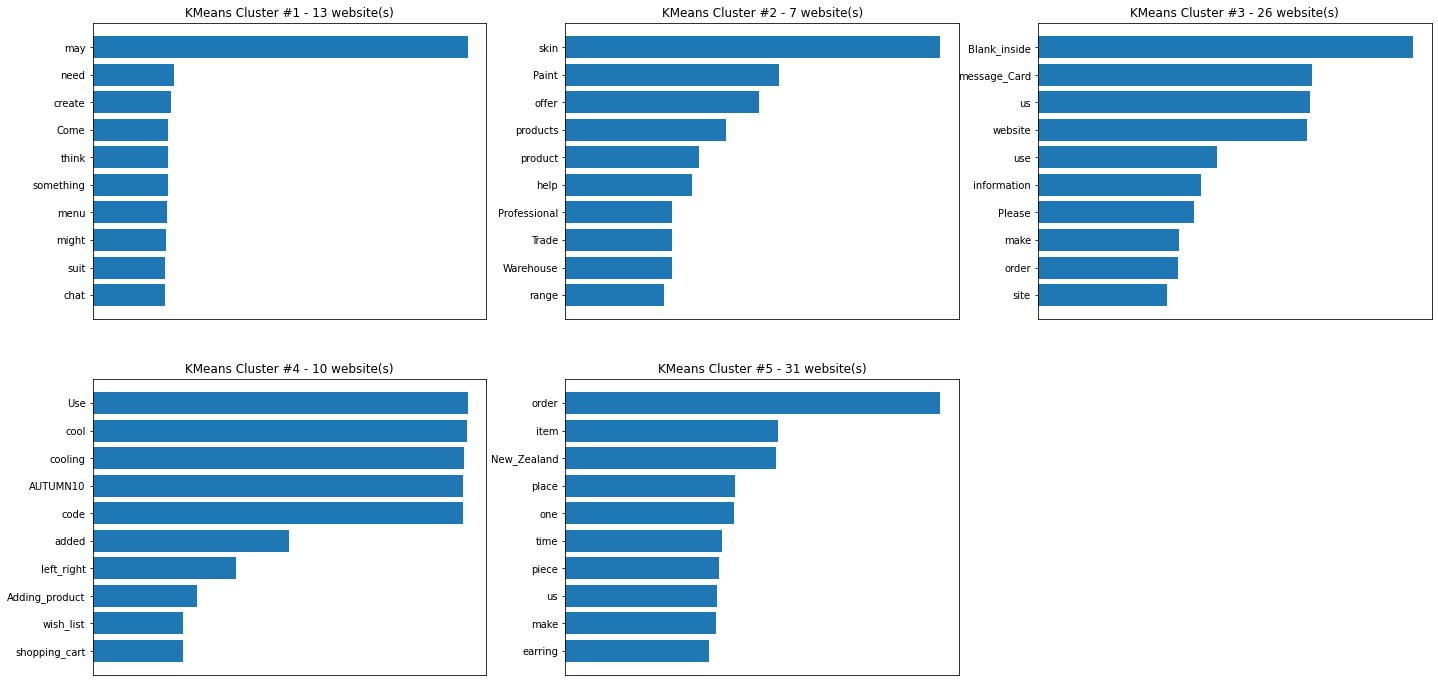

In [62]:
fig, axes = plt.subplots(math.ceil(km.n_clusters / 3), 3,
                         figsize=(24, 6 * math.ceil(km.n_clusters / 3)))
ax = axes.ravel()
for axi in ax:
    axi.set(xticks=[])

for i in range(km.n_clusters): 
    km_mask = km.labels_ == i
    km_websites = websites[ecom_mask][km_mask]
    km_filt_word_freqs = {k: v for k, v in get_avg_word_freqs_bigrams(km_websites).items() 
                          if k not in stops}
    
    top_word_freqs = Counter(km_filt_word_freqs).most_common(10)[::-1]
    y_pos = range(len(top_word_freqs))
    x_pos = [x for word, x in top_word_freqs]
    y_labels = [word for word, x in top_word_freqs]
    
    ax[i].barh(y_pos, x_pos)
    ax[i].set(title=f"KMeans Cluster #{i + 1} - {len(km_websites)} website(s)",
              yticks=y_pos, yticklabels=y_labels)
    
# make unused axes invisible
for i in range(km.n_clusters, len(ax)):
    ax[i].set_visible(False)
    
plt.show()

## MeanShift Clustering of ecommerce websites - FAIL

https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html

In [63]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [64]:
ecom_mask = websites['target'] == 1

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(websites[ecom_mask]['Text'])
bandwidth = estimate_bandwidth(X.toarray(), quantile=0.2, n_samples=50)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X.toarray())

ms.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## DBSCAN-clustered ecommerce websites - FAIL

https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html

In [65]:
from sklearn.cluster import DBSCAN

In [66]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(websites[ecom_mask]['Text'])

db = DBSCAN(eps=2.0).fit(X.todense())
db.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

I think MeanShift and DBSCAN are not well suited to text clustering.

https://stackoverflow.com/questions/33397501/is-it-possible-to-use-mean-shift-clustering-for-text-documents

## Latent Semantic Analysis (Tfidf + LSA)

In [67]:
from sklearn.decomposition import TruncatedSVD

In [71]:
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=777)
svd_model.fit(X)

len(svd_model.components_)

10

In [72]:
terms = vectorizer.get_feature_names()

In [73]:
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print(f"Topic {i}: " + " ".join([t[0] for t in sorted_terms]))

Topic 0: new skin use information products time order
Topic 1: skin environ vitamin oil natural ingredients treatment
Topic 2: broadband skin fibre internet plans compare environ
Topic 3: order shipping amet ut products website orders
Topic 4: broadband amet ut beard ipsum dolor lorem
Topic 5: slideshow cart arrows adding swipe left navigate
Topic 6: shipping orders order items item size delivery
Topic 7: tuturu information products website battery personal litter
Topic 8: sauce like price tbsp low pepper salt
Topic 9: javascript browser disabled tomek cloudflare pick tomorrow


## Latent Dirichlet Allocation